In [30]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("grassknoted/asl-alphabet")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/grassknoted/asl-alphabet/versions/1


In [1]:
import os
import cv2
import numpy as np
import csv
import mediapipe as mp
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import mediapipe as mp
import matplotlib.pyplot as plt
import os

In [10]:
# Define the directory where the training data is stored
train_dir = '/root/.cache/kagglehub/datasets/grassknoted/asl-alphabet/versions/1/asl_alphabet_train/asl_alphabet_train'


# Set up ImageDataGenerator with preprocessing
train_datagen = ImageDataGenerator(rescale=1./255)

# Load the data using flow_from_directory
train_generator = train_datagen.flow_from_directory(
    train_dir,  # Ensure this points to the folder containing the class subfolders
    target_size=(200, 200),
    batch_size=87000,
    class_mode='categorical',  # Multi-class classification
    shuffle=True
)

# Check the class indices
print(train_generator.class_indices)
print(f'Total number of classes: {len(train_generator.class_indices)}')

Found 87000 images belonging to 29 classes.
{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25, 'del': 26, 'nothing': 27, 'space': 28}
Total number of classes: 29


In [11]:
images, labels = next(train_generator)
images.shape, labels.shape

((87000, 200, 200, 3), (87000, 29))

<class 'mediapipe.python.solution_base.SolutionOutputs'>


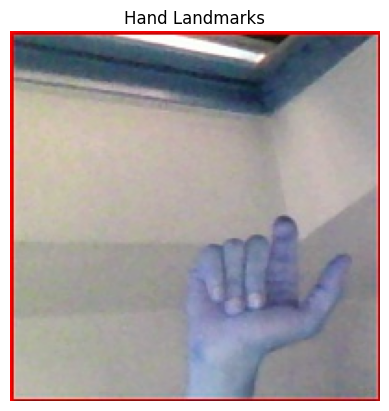

In [12]:
# Initialize MediaPipe Hands
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=2, min_detection_confidence=0.5)
mp_drawing = mp.solutions.drawing_utils

# Assuming 'images' is a list of images loaded as NumPy arrays
image = images[0]

# If the image is in BGR format (from OpenCV), convert it to RGB
if image.shape[2] == 3:  # Ensure it has 3 color channels (BGR or RGB)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Convert the image to uint8 if it's not already in uint8 format
if image.dtype != 'uint8':
    image = (image * 255).astype('uint8')

# Process the image with MediaPipe Hands
results = hands.process(image)

# Print the results to debug
print(results)

# Draw hand landmarks on the image
if results.multi_hand_landmarks:
    for hand_landmarks in results.multi_hand_landmarks:
        mp_drawing.draw_landmarks(image, hand_landmarks, mp_hands.HAND_CONNECTIONS)

# Plot the image with hand landmarks
plt.imshow(image)
plt.title('Hand Landmarks')
plt.axis('off')
plt.show()

In [13]:
valid_images = []
valid_labels = []

# Create a base directory to save the valid images
base_output_dir = './valid_images'
os.makedirs(base_output_dir, exist_ok=True)

# Create a CSV file to save the hand landmark points
csv_file = 'hand_landmarks.csv'
csv_columns = ['image_name'] + [f'x{i}' for i in range(21)] + [f'y{i}' for i in range(21)] + [f'z{i}' for i in range(21)]

labels_dict = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13, 'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20, 'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25, 'del': 26, 'nothing': 27, 'space': 28}

with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(csv_columns)

    for idx, (img, label) in enumerate(zip(images, labels)):
        # Convert the image to RGB if it's in BGR format
        if img.shape[2] == 3:  # Ensure it has 3 color channels (BGR or RGB)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Convert the image to uint8 if it's not already in uint8 format
        if img.dtype != 'uint8':
            img = (img * 255).astype('uint8')

        # Process the image with MediaPipe Hands
        results = hands.process(img)

        # Check if hand landmarks are detected
        if results.multi_hand_landmarks:
            valid_images.append(img)
            valid_labels.append(label)

            # Determine the label directory
            label_index = label.argmax()
            label_name = list(labels_dict.keys())[list(labels_dict.values()).index(label_index)]
            label_dir = os.path.join(base_output_dir, f'{label_name}')
            os.makedirs(label_dir, exist_ok=True)

            # Save the image to file
            filename = os.path.join(label_dir, f'image_{idx}.png')
            cv2.imwrite(filename, cv2.cvtColor(img, cv2.COLOR_RGB2BGR))

            # Extract hand landmark points
            for hand_landmarks in results.multi_hand_landmarks:
                landmarks = [filename]
                for landmark in hand_landmarks.landmark:
                    landmarks.extend([landmark.x, landmark.y, landmark.z])
                writer.writerow(landmarks)

# Convert valid_images and valid_labels to numpy arrays
valid_images = np.array(valid_images)
valid_labels = np.array([list(labels_dict.keys())[list(labels_dict.values()).index(label.argmax())] for label in valid_labels])

print(f'Number of valid images: {len(valid_images)}')
print(f'Hand landmark points saved to {csv_file}')

Number of valid images: 16929
Hand landmark points saved to hand_landmarks.csv
